# _Solanum sp._ Chromosomes 1, 7, and ASR locus (chr. 4)

## Introduction

_Solanum_ is a large genus of over 1200 species of flowering plants in the nightshade family _Solanaceae_. This includes many economically important species like tomatoes (_S. lycospericum_), eggplant (_S. melongena_), and potatoes (_S. tuberosum_). The phylogeny is complex, but mostly contains two larger clades ([Messeder et. al.](https://doi.org/10.1111/nph.19849)), of which Clade I contains tomatoes (informally, section _Lycopersicon_). 

![tomato phylogeny](data/tomato_clades_messeder.png)

Moderm tomatoes are mostly varieites of _S. lycospericum_, but wild species and wild-crop hybrids grow readily in warm regions of the Americas. It is proposed that _S. pimpinellifolium_ may be a wild ancestor of modern tomatoes, and may have contributed a significant portion of genetic material to _S. lycospericum_. However, more recent admixture has occured, either naturally by intentional breeding, that has conferred traits like disease resistance into moderm varieties ([Menda et. al.](https://doi.org/10.1186/s12870-014-0287-2))

Here, I propose an analysis on chromosomes 1 and 7 of the tomato genome to detect introgressive and selective signals, particularly at loci connected to drought tolerance (below):

- __Chromosome 1__ (SlAREB1, PRXIIF, SAP5, REF4-1, LCD, CCD1, SCS)
- __Chromosome 7__ (Sec14-like PITP, AHG2, PRXQ, CFS1)
- __ASR locus (Chromosome 4)__ (ASR1 and ASR4)

## Methods

This analysis will leverage SNP data from the __Sol Genomics Network__'s ["varitome project"](https://solgenomics.sgn.cornell.edu/projects/varitome). First we will convert vcf files to hdf5, extract relevant samples, and perform PCA, nucleotide diversity, pairwise Fst, and D+ tests.

#### __Step 1:__ Data `.vcf` to `.h5` processing

In [13]:
import ipyrad.analysis as ipa
import pandas as pd
import sklearn
import numpy as np
import allel

In [14]:
%%bash

# compress the VCF file if not already done (creates .vcf.gz)
# bgzip data/ch07.vcf

# remove multi-allelic SNPs and INDELs and PIPE to next command
bcftools view --types snps -Ou -o data/ch07.cleaned.vcf data/ch07.vcf.gz

# recompress the final file (create .vcf.gz)
bgzip data/ch07.cleaned.vcf

In [15]:
allel.vcf_to_hdf5('data/ch07.cleaned.vcf.gz', 'analysis-vcf2hdf5/ch07.cleaned.h5')

In [16]:
# # load the VCF as an datafram
# dfchunks = pd.read_csv(
#     "data/ch01.cleaned.vcf.gz",
#     sep="\t",
#     skiprows=1000,
#     chunksize=1000,
# )

# # show first few rows of first dataframe chunk
# next(dfchunks).head()

In [17]:
# # init a conversion tool
# converter = ipa.vcf_to_hdf5(
#     name="S.lycospericum_chr7",
#     data="data/ch07.cleaned.vcf.gz",
#     ld_block_size=20000,
# )

# # run the converter
# converter.run()

In [18]:
# pca = ipa.pca(
#     data="./analysis-vcf2hdf5/S.lycospericum_chr7.snps.hdf5",
#     mincov=1.0,
# )

#### __Step 2:__ Extracting and transforming `.h5` data

In [19]:
# Import modules.
import allel
import h5py
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns

In [20]:
# Load the hdf5 data.
chr7_data = h5py.File('./analysis-vcf2hdf5/ch07.cleaned.h5', mode='r')
# Extract the genotypes.
chr7_gt = allel.GenotypeArray(chr7_data['calldata/GT'][:])
# Extract the variable positions array.
chr7_pos = allel.SortedIndex(chr7_data['variants/POS'][:])
# Extract the samples array.
chr7_samps = np.array([samp.decode() for samp in chr7_data['samples'][:]])

In [21]:
chr7_length = 68045021

# Adjust the total chromosome length for 50kb windows.
chr7_adj_len = (chr7_length // 50_000) * 50_000
# Intialize a dicctionary with the start and stop position for each window.
wind_dicc = {}
# Intialize a midpoint list.
mid_points = []
# Intialize a window index counter.
index = 0
# For all 50kb window...
for window_start in range(1, chr7_length, 50_000):
    # If this is the last window...
    if window_start == chr7_length:
        # Break the for loop since there are too few sites in the last window.
        break
    # Else...
    else:
        # Fill the dictionary with the position indices.
        wind_dicc[index] = np.where(((window_start <= chr7_pos) & (chr7_pos < (window_start + 50_000))))[0]
        # Append the midpoint list.
        mid_points.append(window_start + 25_000)
        # Move the window index forward.
        index += 1
# # Determine the optix gene indices.
# optix_idx = np.where(((1058778 <= chr7_pos) & (chr7_pos <= 1159581)))[0]
# # Intialize the windows the optix gene is in.
# optix_wind = np.array([21, 22, 23])
# # Intialize the x-axis ticks.
# x_ticks = np.arange(0, 350, 30)
# # Intialize the x-axis tick labels.
# x_labels = (np.arange(0, chr78_adj_len, 1_500_000) / 1_000_000).astype(str)

In [22]:
# Extract the species id from samples labels.
species_id = [sample.split('_')[0] for sample in chr7_samps]
# Create a metadata dataframe.
chr7_meta_df = pd.DataFrame({'samples': chr7_samps, 'species': species_id})
# Extract the unique sample ids.
chr7_species = chr7_meta_df['species'].unique()
# Subset the focal species.
focal_chr7_species = chr7_species[:-1]
# Intialize a dictionary to store sample ids.
chr7_idx_dicc = {}
# For every species...
for spc in chr7_species:
    # Fill the dictionary.
    chr7_idx_dicc[spc] = chr7_meta_df[chr7_meta_df['species'] == spc].index.values

In [23]:
# Convert the genotypes to an alternative allele count matrix.
chr7_aac = chr7_gt.to_n_alt(fill=np.nan, dtype=np.float64)
# Intialize an allele count matrix dictionary.
chr7_aac_dicc = {}
# intialize a alternative allele frequency dictionary.
chr7_freq_dicc = {}
# For every species...
for spc in chr7_species:
    # Fill the dictionary with the subsetted alternative allele count matrix.
    chr7_aac_dicc[spc] = chr7_aac[:, chr7_idx_dicc[spc]]
    # Determine the number of chromosomes with allele calls.
    called_chroms = np.count_nonzero(~np.isnan(chr7_aac_dicc[spc]), axis=1) * 2
    # Determine the allele counts of the derived/alternative allele.
    per_site_aac = np.nansum(chr7_aac_dicc[spc], axis=1)
    # Fill the frequency dictionary.
    chr7_freq_dicc[spc] = per_site_aac / called_chroms

/var/folders/wg/d2mg01mn4796lx7m_nt42y600000gn/T/ipykernel_14162/2339683515.py:16: RuntimeWarning: invalid value encountered in divide
  chr7_freq_dicc[spc] = per_site_aac / called_chroms


#### __Step 3:__ PCA on all samples

In [24]:
# Get Solanum lycopersicum var. cerasiforme (SLC) and var. lycopersicum (SLL) sample ids.

slc_metadata = pd.read_csv('data/metadata/SLC_metadata.csv')
sll_metadata = pd.read_csv('data/metadata/SLL_metadata.csv')

slc_samps = np.array(slc_metadata.Label.unique())
sll_samps = np.array(sll_metadata.Label.unique())

# Get Solanum pennellii (SP) sample ids.
sp_metadata = pd.read_csv('data/metadata/SP_metadata.csv')
sp_samps = np.array(sp_metadata.Label.unique())


In [58]:
slc_aac = np.concatenate([chr7_aac_dicc[samp] for samp in slc_samps], axis=1)
sll_aac = np.concatenate([chr7_aac_dicc[samp] for samp in sll_samps], axis=1)

sp_aac = np.concatenate([chr7_aac_dicc[samp] for samp in sp_samps], axis=1)

all_aac = np.concatenate([slc_aac, sll_aac, sp_aac], axis=1)
all_aac = np.nan_to_num(all_aac, nan=0)
# all_aac = np.nan_to_num(slc_aac, nan=0)

In [59]:
print(slc_aac.shape) # needs 106?.. update metadata
print(sll_aac.shape)
print(sp_aac.shape)
print(all_aac.shape)

(663742, 103)
(663742, 20)
(663742, 26)
(663742, 149)


In [60]:
# Calculate the column mean vector.
mu_vec = np.mean(all_aac, axis=0)
# Calculate the column allele frequency vector.
p_vec = mu_vec / 2
# Calculate the standard deviation vector.
std_vec = np.sqrt(((all_aac.shape[0] * 2) * p_vec * (1 - p_vec)))
# Convert the C matrix to a zero centered M matrix.
M_mat = (all_aac - mu_vec) / std_vec

In [61]:
# Compute the covariance matrix.
X_mat = np.cov(M_mat, rowvar=False)

In [62]:
# Compute the eigen -values and -vectors.
eig_vals, eig_vecs = np.linalg.eig(X_mat)
# Sort the -values and -vectors.

# Sort the eigen vales and pick the corresponding eigen vectors (Principal components)
eig_idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[eig_idx]
eig_vecs = eig_vecs[:, eig_idx]

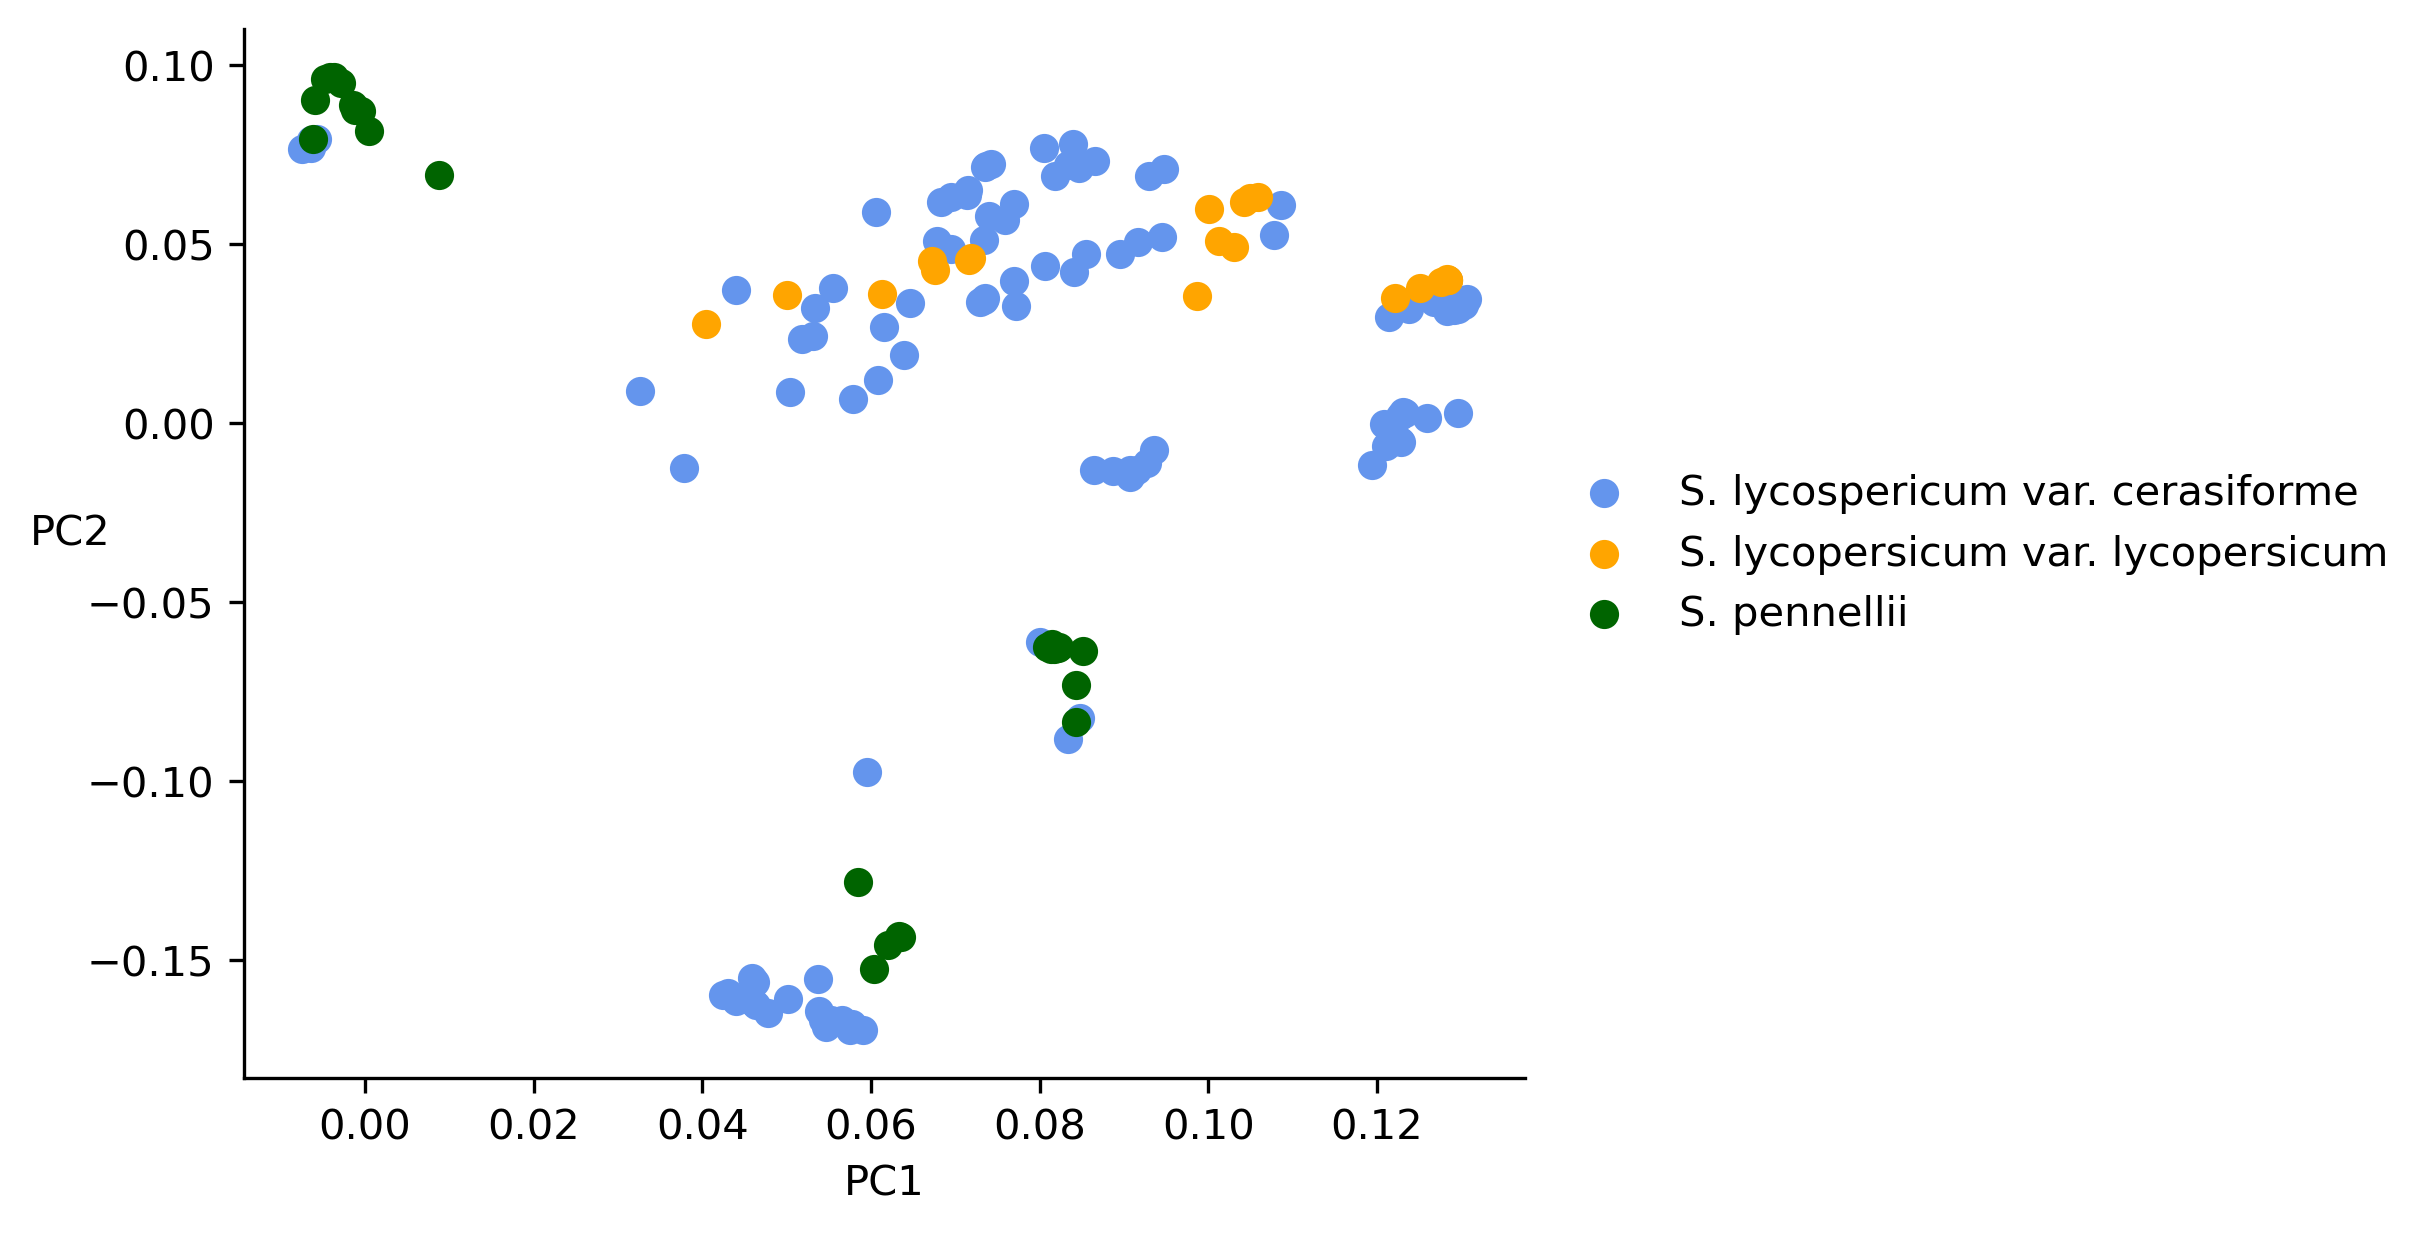

In [63]:
## PLOTTING ##

# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)

# Plot points
ax.scatter(
    eig_vecs[:103, 0], eig_vecs[:103, 1],
    color='cornflowerblue', label='S. lycospericum var. cerasiforme',
)
ax.scatter(
    eig_vecs[103:123, 0], eig_vecs[103:123, 1],
    color='orange', label='S. lycopersicum var. lycopersicum',
)
ax.scatter(
    eig_vecs[123:, 0], eig_vecs[123:, 1],
    color='darkgreen', label='S. pennellii',
)

# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Plot the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('PC1')
plt.ylabel('PC2', rotation=0)
# Show!
plt.show()

#### __Step 3:__ Geography subset PCA on _S. lyco. var. cerasiforme_

In [69]:
slc_locs = slc_metadata.Origin.unique()
print(slc_locs)

['Ecuador' 'Peru' 'Mexico' 'Costa Rica' 'El Salvador' 'Honduras'
 'Colombia' 'Nicaragua']


In [83]:
slc_meta_dicc = {}
for loc in slc_locs:
    slc_meta_dicc[loc] = slc_aac[:, slc_metadata.Origin == loc]

# slc_meta_dicc = {
#     'ECU' : slc_metadata[:, slc_metadata.Origin == 'Ecuador'],
#     'PER' : slc_metadata[:, slc_metadata.Origin == 'Peru'],
#     'MEX' : slc_metadata[:, slc_metadata.Origin == 'Mexico'],
#     'COS' : slc_metadata[:, slc_metadata.Origin == 'Costa Rica'],
#     'ELS' : slc_metadata[:, slc_metadata.Origin == "El Salvador"],
# }

In [87]:
print([mat.shape for mat in slc_meta_dicc.values()])

[(663742, 40), (663742, 29), (663742, 21), (663742, 5), (663742, 2), (663742, 2), (663742, 3), (663742, 1)]


In [88]:
slc_aac = np.nan_to_num(slc_aac, nan=0)

def calc_pca(aac_mat):
    # Calculate the column mean vector.
    mu_vec = np.mean(aac_mat, axis=0)
    # Calculate the column allele frequency vector.
    p_vec = mu_vec / 2
    # Calculate the standard deviation vector.
    std_vec = np.sqrt(((aac_mat.shape[0] * 2) * p_vec * (1 - p_vec)))
    # Convert the C matrix to a zero centered M matrix.
    M_mat = (aac_mat - mu_vec) / std_vec

    # Compute the covariance matrix.
    X_mat = np.cov(M_mat, rowvar=False)

    # Compute the eigen -values and -vectors.
    eig_vals, eig_vecs = np.linalg.eig(X_mat)
    # Sort the -values and -vectors.

    # Sort the eigen vales and pick the corresponding eigen vectors (Principal components)
    eig_idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[eig_idx]
    eig_vecs = eig_vecs[:, eig_idx]

    return eig_vals, eig_vecs

eig_vals, eig_vecs = calc_pca(slc_aac)

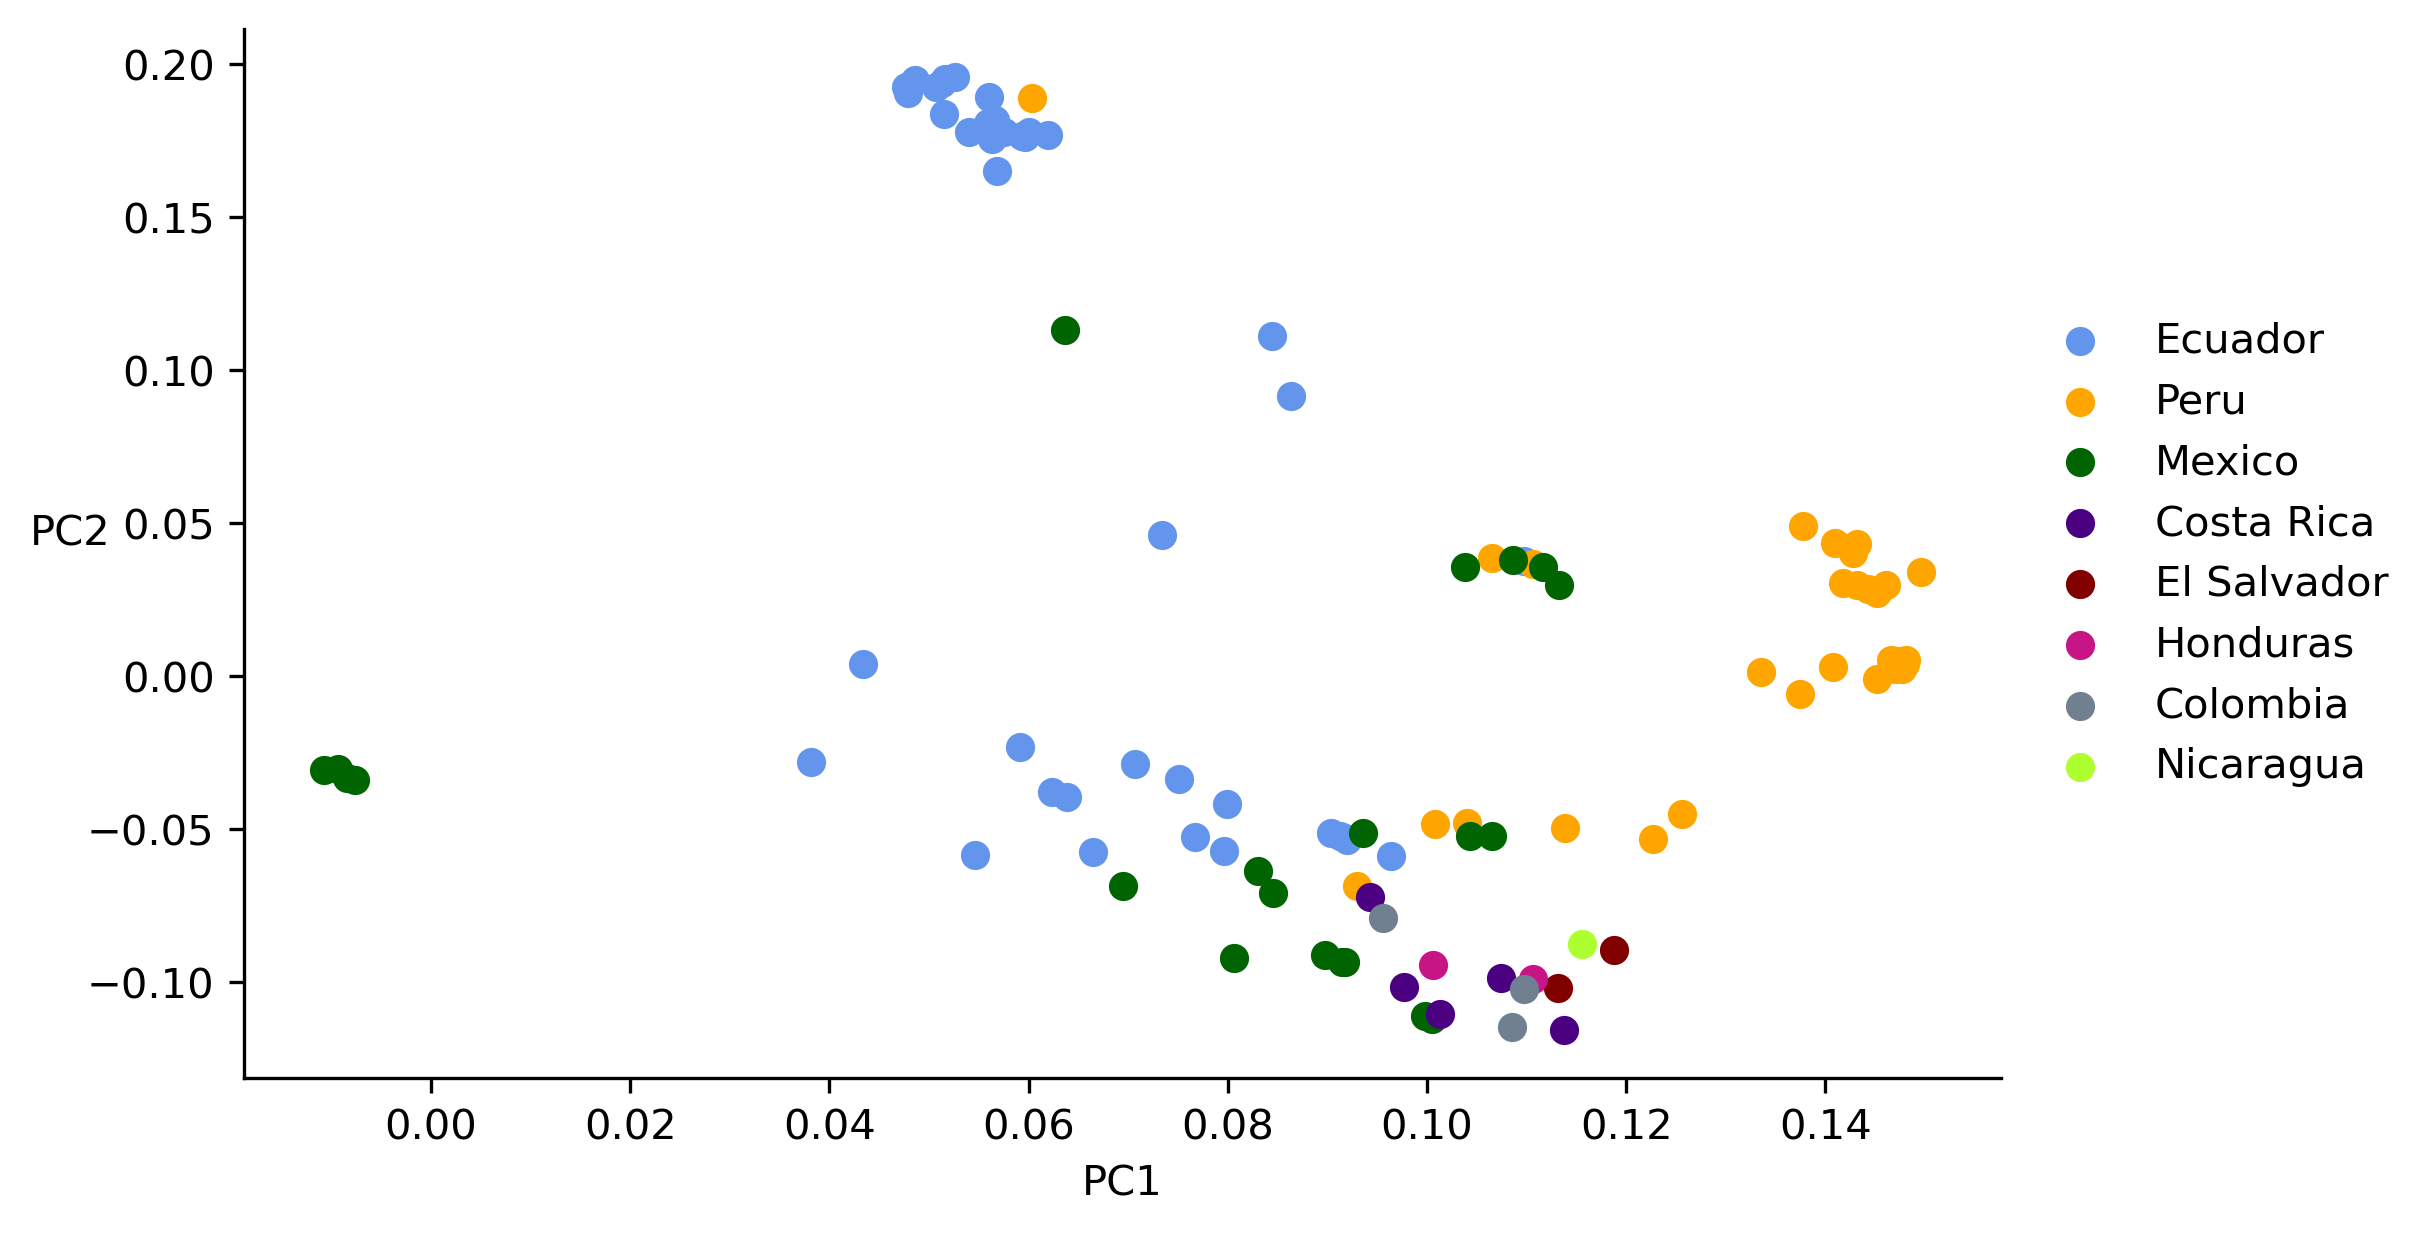

In [89]:
## PLOTTING ##

# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)

# Plot points
ax.scatter(
    eig_vecs[:40, 0], eig_vecs[:40, 1],
    color='cornflowerblue', label='Ecuador',
)
ax.scatter(
    eig_vecs[40:69, 0], eig_vecs[40:69, 1],
    color='orange', label='Peru',
)
ax.scatter(
    eig_vecs[69:90, 0], eig_vecs[69:90, 1],
    color='darkgreen', label='Mexico',
)
ax.scatter(
    eig_vecs[90:95, 0], eig_vecs[90:95, 1],
    color='indigo', label='Costa Rica',
)
ax.scatter(
    eig_vecs[95:97, 0], eig_vecs[95:97, 1],
    color='maroon', label='El Salvador',
)
ax.scatter(
    eig_vecs[97:99, 0], eig_vecs[97:99, 1],
    color='mediumvioletred', label='Honduras',
)
ax.scatter(
    eig_vecs[99:102, 0], eig_vecs[99:102, 1],
    color='slategray', label='Colombia',
)
ax.scatter(
    eig_vecs[102:, 0], eig_vecs[102:, 1],
    color='greenyellow', label='Nicaragua',
)

# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Plot the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('PC1')
plt.ylabel('PC2', rotation=0)
# Show!
plt.show()